In [11]:
from svg.path import parse_path # requires svg.path: pip install svg.path
from svg.path.path import Line
from xml.dom import minidom
from PyPDF2 import PdfFileReader # requires PyPDF2: pip install PyPDF2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import os, sys
import os.path
import subprocess
from skfda import FDataGrid
import sklearn
from itertools import combinations
from skfda.ml.clustering import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import time
import math
import sklearn.cluster as sk
from skfda.preprocessing.dim_reduction.projection import FPCA
import statistics as st
from scipy import stats
import random
from skfda.misc.metrics import l2_distance, TransformationMetric, LpDistance, fisher_rao_distance, linf_distance
import hipoxia_clean_data as cd
import importlib
sys.path.append('dahfi_main/database_ctu-chb/')

from src.data import load_FHR_UC, load_targets, load_features_targets
from src.preprocessing import preprocessing_signals, remove_long_gaps, all_zero_move

Cargamos los datos

In [2]:
target = load_targets(pH=7.2, path_csv='dahfi_main/database_ctu-chb/data/')
fd_fhr, fd_uc, target2 = cd.get_fhr_uc(target = target)

Loading data
Removing Nans
Transformation to FDataGrid


Cargamos las variables con las que compararemos los resultados

In [3]:
path_csv_features = 'dahfi_main/database_ctu-chb/features/comert_features/'
preprocess_method = 'comert_gaps'
features = pd.read_csv(path_csv_features+preprocess_method+'_features.csv', index_col=0)

X = features[features.columns[0:3].tolist() + features.columns[4:5].tolist()]
mean = np.array(features['mean'])
dcc = np.array(features['DCC'])
acc = np.array(features['ACC'])
std = np.array(features['std'])
baseline = np.array(features['baseline'])

Por facilidad añadimos a nuestros datos la columna del pH, aunque los únicos objetivos de estos son comparativos, nunca para hacer clústering partiendo de dicho valor

In [4]:
clinical_df = pd.read_csv('dahfi_main/database_ctu-chb/data/clinical_ctu-chb.csv', index_col=0, compression='gzip')
pH = clinical_df['ph']
X['pH'] = pH
X['target'] = target

 /home/ejerez/Escritorio/UNI/QUINTO/Matrícula y TFGs/TFG/codigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /home/ejerez/Escritorio/UNI/QUINTO/Matrícula y TFGs/TFG/codigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
'''
    Función para guardar datos en un csv
'''
def save_csv(filename, header, data, sort_column=None):
    df = pd.DataFrame(data, columns=header)
    if os.path.isfile(filename):
        df2 = pd.read_csv(filename)
        df = pd.concat([df, df2]).drop_duplicates()
        
    if sort_column:
        df = df.sort_values(by=[sort_column], ascending=False)
    df.to_csv(filename,index=False)

In [6]:
''' 
    Función para generar diagramas de cajas a partir de ciertos datos.
'''
def showBoxPlot(data, xticklables = None, title=None, suptitle = None, save=False, nplots = None):
    # More than one subplot
    if nplots:
        values = []
        fig, ax = plt.subplots(1,nplots)
        for i in range(0, nplots):
            if title is not None:
                ax[i].set_title(title[i])
            val = ax[i].boxplot(data[i])
            values += [val]
            if xticklables is not None:
                ax[i].set_xticks(ax[i].get_xticks())
                ax[i].set_xticklabels(xticklables)
        
        fig.set_size_inches(4*nplots, 4)
        if suptitle:
            fig.suptitle(suptitle , fontsize=16)
    #Just one subplot
    else:
        _, ax = plt.subplots()

        if title:
            ax.set_title(title)
        
        values = ax.boxplot(data)

        if xticklables:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(xticklables)
        if suptitle:
            fig.suptitle(suptitle , fontsize=16)

    
    if save:
        p = plt.savefig("img/boxplots/" + save + ".png",dpi=300)
        
    plt.show()
    return values


In [7]:
'''
    Función que dado un array, devuelve las posiciones en dicho array de los elementos que coincidan con el deseado
    input:
            preds: array a estudiar
            n_cluster: elemento que buscamos en el array
    output:
            lista de indices en el array
'''
def get_index_of_clusters(preds, n_cluster):
    index = []
    for i in range(0, len(preds)):
        if preds[i] == n_cluster:
            index += [i]
    return index

In [8]:
'''
    Función que itera para aplicar K medias para un rango de número de clústers. Para cada número de clústers genera diagramas de cajas comparando ciertas 
    características de los clústers.

    start: número de clústers con el que empieza 
    stop: número de clústers con los que termina
    data: datos a los que aplicar k medias (formato ya en FDataGrid)
    functional: booleano que toma True si los datos son funcionales, o False si son multivariantes
    save: None si no queremos guardar los resultados, 'Nombre del fichero' en caso afirmativo
    boxplot: es una lista de argumentos, que tendrán valor diferente a None en caso que se quieran realizar los diagramas de cajas
            Tiene la forma [lista de caracteristicas, lista de titulos]
    return: tupla con - valor máximo de precision alcanzada
                      - lista que nos indica que combinación de las predicciones hemos utilizado
                      - Si se alcanza con dicho orden o al revés
'''
def KMeans_iterate (start, stop, data, functional = True, save = False, box_plot = [None,None], metric = LpDistance(p=2, vector_norm=None)):
    
    savings = []
    preds = {}
    
    header = ['Seed', 'Number of clusters']

    for n_clusters in range(start, stop):
        print("Computing for %d clusters" %n_clusters)
        seed = math.floor(time.time())

        if functional:
            kmeans = KMeans(n_clusters=n_clusters, metric = metric, random_state=seed).fit(data)
        else:
            kmeans = sk.KMeans(n_clusters=n_clusters, metric = metric, random_state=seed).fit(data)
            
        pred = kmeans.predict(data)
        preds[n_clusters] = pred
        savings += [[seed, n_clusters]]

        if box_plot[0] is not None:
            #Obtenemos el número de boxplots que realizaremos por cada ejecución de K medias.
            n_subplots = len(box_plot[0])
            if n_subplots > 1:
                boxplot_data = []
                for i in range(0, n_subplots):
                    clusters = {}
                    xlabels = []
                    for j in range(0,n_clusters):
                        # Get indexes of cluster j
                        ind = get_index_of_clusters(preds=list(preds[n_clusters]), n_cluster=j)
                        #Obtain characteristic for that cluster
                        clusters[j] = [list(box_plot[0][i])[ele] for ele in ind]
                        xlabels += ["Cluster "+ str(j)]
                    boxplot_data += [list(clusters.values())]
                showBoxPlot(data= boxplot_data, xticklables = tuple(xlabels), title = box_plot[1], nplots=n_subplots, save = 'boxplot_fd_supremo' + str(seed))  
            else:
                combined = list(map(lambda x,y: [x,y] ,box_plot[0][0], list(preds[n_clusters])))
                clusters = {}
                xlabels = []
                for i in range(0,n_clusters):
                    clusters[i] = list(map(lambda ele: ele[0], filter(lambda n:  n[1] == i,combined)))
                    xlabels += ["Cluster "+ str(i)]
                showBoxPlot(data= list(clusters.values()), xticklables = tuple(xlabels), title = box_plot[1], save = 'bocplot_fd_euclidea' + str(seed), suptitle ="K = "+ str(n_clusters))
            
    if save:
        save_csv(filename = 'seeds.txt', header = header, data=savings, sort_column='Seed')
    return preds, savings

# K medias
Intentamos estudiar los datos directamente aplicando el algoritmo de K medias, y estudiando los clústers que obtenemos

Computing for 2 clusters


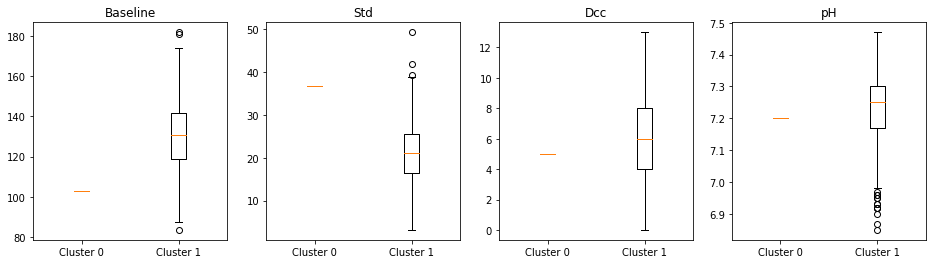

Computing for 3 clusters


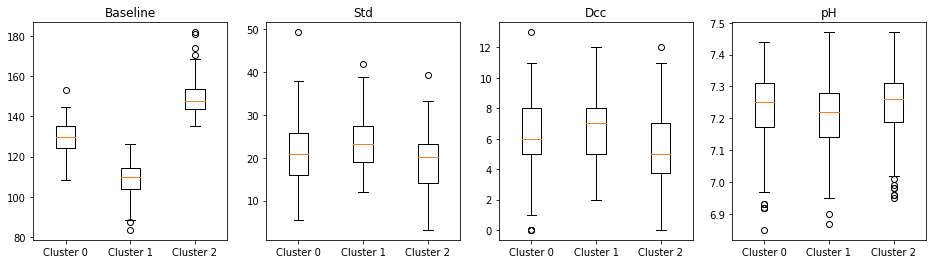

Computing for 4 clusters


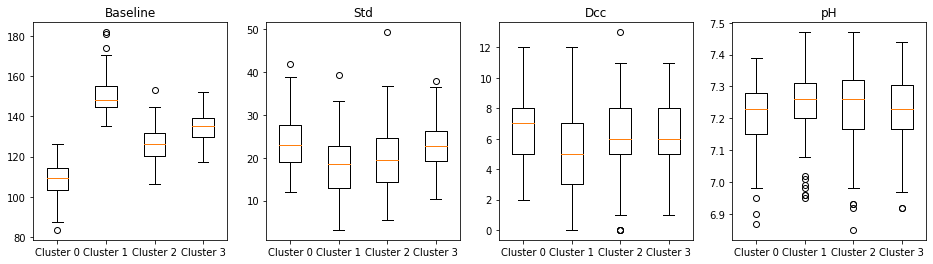

In [9]:
#Probamos con distancia euclídea 
ret = KMeans_iterate(2,5, data=fd_fhr, functional=True,
                    box_plot=[[baseline, std, dcc, pH], 
                    ["Baseline", "Std", "Dcc", 'pH']])

Computing for 2 clusters


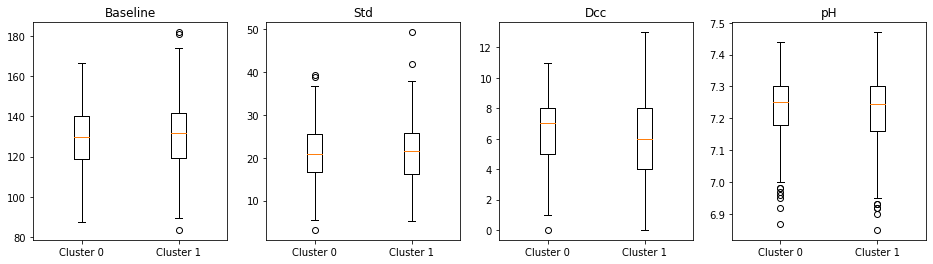

Computing for 3 clusters


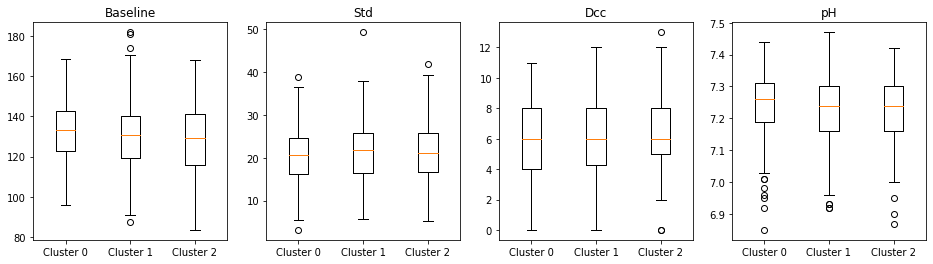

Computing for 4 clusters


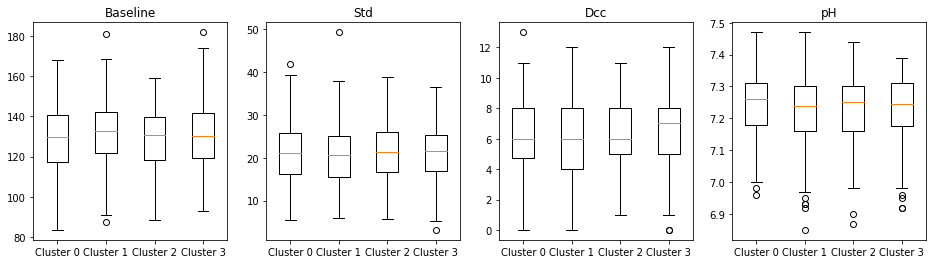

In [12]:
# Ahora con distancia del supremo

dist = TransformationMetric(transformation=lambda x: x.derivative(), metric = linf_distance)
ret = KMeans_iterate(2,5, data=fd_fhr, functional=True,
                    metric = dist,
                    box_plot=[[baseline, std, dcc, pH], 
                    ["Baseline", "Std", "Dcc", 'pH']])

# Clústring Jerárquico

In [13]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    distance = np.arange(model.children_.shape[0])

    linkage_matrix = np.column_stack(
        [model.children_, distance, counts]
    ).astype(float)

    # Plot the corresponding dendogram
    dendrogram(linkage_matrix, **kwargs)

In [14]:
# Con similitud simple
clustering = AgglomerativeClustering(distance_threshold=0, 
            n_clusters = None, 
            metric = linf_distance,
            linkage=AgglomerativeClustering.LinkageCriterion.SINGLE)
model = clustering.fit(fd_fhr)
pred = clustering.labels_.astype(np.int_)

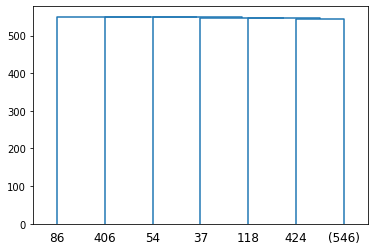

In [15]:

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p = 7)
p = plt.savefig("img/dendograms/completoFUN.png",dpi=300)
plt.show()

In [16]:
# Con similitud media
clustering = AgglomerativeClustering(distance_threshold=0, 
            n_clusters = None, 
            metric = linf_distance,
            linkage=AgglomerativeClustering.LinkageCriterion.AVERAGE)
model = clustering.fit(fd_fhr)
pred = clustering.labels_.astype(np.int_)

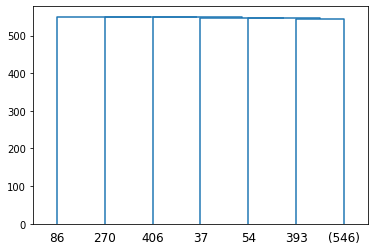

In [17]:

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p = 7)
p = plt.savefig("img/dendograms/completoFUN.png",dpi=300)
plt.show()

In [18]:
# Con similitud completa
clustering = AgglomerativeClustering(distance_threshold=0, 
            n_clusters = None, 
            metric = linf_distance,
            linkage=AgglomerativeClustering.LinkageCriterion.COMPLETE)
model = clustering.fit(fd_fhr)
pred = clustering.labels_.astype(np.int_)

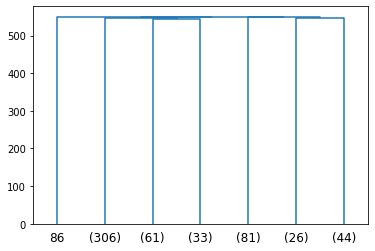

In [19]:
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p = 7)
p = plt.savefig("img/dendograms/completoFUN.png",dpi=300)
plt.show()

Estudiamos las características de esta última, que parece mas coherente

In [20]:
pred = {}
for n_clst in range(4,6):
    clustering = AgglomerativeClustering(
                metric = linf_distance,
                n_clusters = n_clst, 
                linkage=AgglomerativeClustering.LinkageCriterion.COMPLETE)
    clustering.fit(fd_fhr)
    pred[n_clst] = clustering.labels_.astype(np.int_)

Computing for 4 clústers


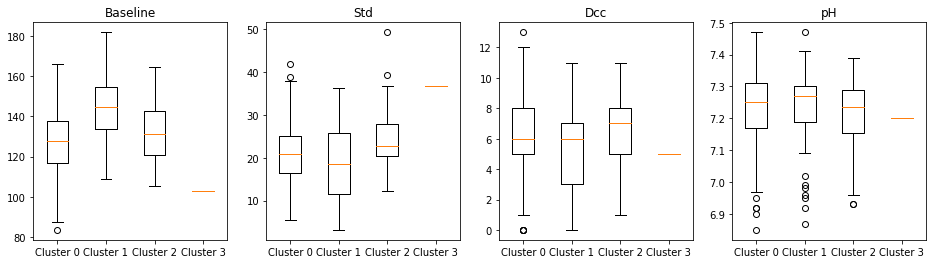

Computing for 5 clústers


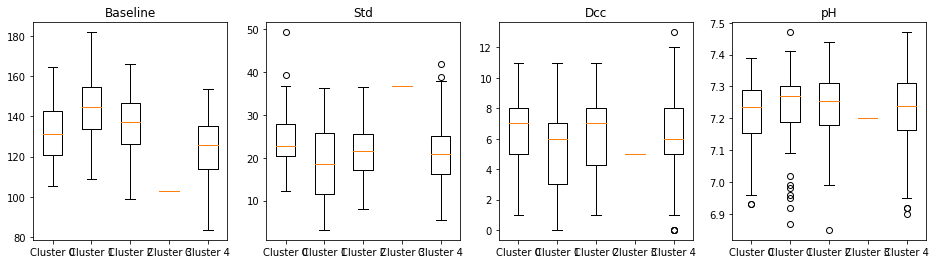

In [21]:
box_plot = [[baseline, std, dcc, pH], ["Baseline", "Std", "Dcc", "pH"]]
n_subplots = len(box_plot[0])
similitud = 'completa'
for n_clusters in range(4,6):
    print('Computing for ' + str(n_clusters) + ' clústers')
    boxplot_data = []
    for i in range(0, n_subplots):
        clusters = {}
        xlabels = []
        for j in range(0,n_clusters):
            # Get indexes of cluster j
            ind = get_index_of_clusters(preds=list(pred[n_clusters]), n_cluster=j)
            #Obtain characteristic for that cluster
            clusters[j] = [list(box_plot[0][i])[ele] for ele in ind]
            xlabels += ["Cluster "+ str(j)]
        boxplot_data += [list(clusters.values())]
    showBoxPlot(data= boxplot_data, xticklables = tuple(xlabels), title = box_plot[1], nplots=n_subplots, save = similitud+str(n_clusters))
            